## Imports

In [1]:
from crop_detection.cropped_pairs import CroppedPairs

from sconce.data_feeds import DataFeed
from sconce.models.base import Model
from sconce.models.layers import AdaptiveAveragePooling2dLayer, Convolution2dLayer, FullyConnectedLayer
from sconce.parameter_group import ParameterGroup
from sconce.schedules import Cosine
from sconce.trainer import Trainer
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.models import resnet18, resnet34

import numpy as np
import os
import sconce
import torch
import crop_detection

print(f"Notebook was run with pytorch-sconce version: {sconce.__version__}")

Notebook was run with pytorch-sconce version: 1.3.0


In [2]:
dataset = CroppedPairs(root='data/dogscats/test1', image_size=64, variations=30, cat_dim=2)

# standard DataFeed can't handle this shape of targets properly
class MyDataFeed(DataFeed):
    def preprocess(self, inputs, targets):
        if self._inputs_cuda is False:
            inputs = inputs.cpu()
        else:
            inputs = inputs.cuda(self._inputs_cuda)

        if self._targets_cuda is False:
            if isinstance(targets, torch.Tensor):
                targets = targets.cpu()
        else:
            targets = [t.cuda(self._targets_cuda) for t in targets]

        return inputs, targets

training_feed, validation_feed = MyDataFeed.from_dataset(dataset=dataset, split=0.8,
                                                       batch_size=100, num_workers=7, shuffle=True)
if torch.cuda.is_available():
    training_feed.cuda()
    validation_feed.cuda()

In [3]:
from sconce.models.base import Model
from sconce.models.layers import Convolution2dLayer, AdaptiveAveragePooling2dLayer, FullyConnectedLayer
from torch import nn

import numpy as np
import torch


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class CropDetectionModel(Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        
        self.base1 = nn.Sequential(
            self.base_model.conv1,
            self.base_model.bn1,
            self.base_model.relu,
            self.base_model.maxpool,
            
            self.base_model.layer1,
            self.base_model.layer2,
        )
        self.base2 = nn.Sequential(
            self.base_model.layer3,
            self.base_model.layer4,
        )
        self.feature_extractor = nn.Sequential(
            self.base1,
            self.base2
        )

        in_size = 512*8
        self.is_paired_classifier = nn.Sequential(
            Flatten(),
            FullyConnectedLayer(in_size=in_size, out_size=100, activation=nn.ReLU(inplace=True), dropout=0.5),
            FullyConnectedLayer(in_size=100, out_size=100, activation=nn.ReLU(inplace=True), dropout=0.3),
            FullyConnectedLayer(in_size=100, out_size=2, activation=None),
            nn.LogSoftmax(dim=1),
        )

        self.is_swapped_classifier = nn.Sequential(
            Flatten(),
            FullyConnectedLayer(in_size=in_size, out_size=100, activation=nn.ReLU(inplace=True), dropout=0.5),
            FullyConnectedLayer(in_size=100, out_size=100, activation=nn.ReLU(inplace=True), dropout=0.3),
            FullyConnectedLayer(in_size=100, out_size=2, activation=None),
            nn.LogSoftmax(dim=1),
        )

        self.xy_regressor = nn.Sequential(
            Flatten(),
            FullyConnectedLayer(in_size=in_size, out_size=100, activation=nn.ReLU(inplace=True), dropout=0.5),
            FullyConnectedLayer(in_size=100, out_size=100, activation=nn.ReLU(inplace=True), dropout=0.3),
            FullyConnectedLayer(in_size=100, out_size=2, activation=None),
            nn.Sigmoid(),
        )
        self.alpha = 0.0
        
    def build_parameter_groups(self):
        super().build_parameter_groups()
        head_parameters = (list(self.is_paired_classifier.parameters()) + 
                           list(self.is_swapped_classifier.parameters()) + 
                           list(self.xy_regressor.parameters()))
        head_group = ParameterGroup(parameters=head_parameters, name='head')
        self.add_parameter_group(head_group)
        
        base1_parameters = list(self.base1.parameters())
        base1_group = ParameterGroup(parameters=base1_parameters, name='base1')
        base1_group.unfreeze()
        self.add_parameter_group(base1_group)
                                
        base2_parameters = list(self.base2.parameters())
        base2_group = ParameterGroup(parameters=base2_parameters, name='base2')
        base2_group.unfreeze()
        self.add_parameter_group(base2_group)
        
    def forward(self, inputs, **kwargs):
        features = self.feature_extractor(inputs)

        is_paired = self.is_paired_classifier(features)
        is_swapped = self.is_swapped_classifier(features)
        xy = self.xy_regressor(features)

        return dict(outputs=xy, is_paired=is_paired, is_swapped=is_swapped)

    def set_alpha(self, value):
        self.alpha = float(value)

    def calculate_loss(self, targets, outputs, is_paired, is_swapped, **kwargs):
        paired_targets = targets[0].squeeze()
        swapped_targets = targets[1].squeeze()
        xy_targets = targets[2]

        paired_loss = F.nll_loss(input=is_paired, target=paired_targets)

        mask = paired_targets.float()
        s = F.nll_loss(input=is_swapped, target=swapped_targets, reduce=False) * mask
        swapped_loss = torch.sum(s) / torch.sum(mask)

        s = (outputs - xy_targets).pow(2) * mask.unsqueeze(dim=1)
        xy_loss = torch.sum(torch.sum(s, dim=1)) / torch.sum(mask)

        total_loss = (1.0 - self.alpha) * (paired_loss + swapped_loss) + (self.alpha) * xy_loss
        return dict(loss=total_loss, paired_loss=paired_loss, swapped_loss=swapped_loss, xy_loss=xy_loss)

    def calculate_metrics(self, targets, outputs, is_paired, is_swapped, **kwargs):
        paired_out = np.argmax(is_paired.cpu().data.numpy(), axis=1)
        paired_targets = targets[0].squeeze()
        paired_in = paired_targets.cpu().data.numpy()
        num_correct = (paired_out - paired_in == 0).sum()
        paired_accuracy = num_correct / len(paired_in)


        swapped_targets = targets[1].squeeze()
        swapped_in = swapped_targets.cpu().data.numpy()

        swapped_out = np.argmax(is_swapped.cpu().data.numpy(), axis=1)
        mask = paired_in
        swapped_out_masked = np.where(mask, swapped_out, 2*np.ones(swapped_out.shape))

        swapped_num_correct = (swapped_in - swapped_out_masked == 0).sum()
        swapped_accuracy = swapped_num_correct / mask.sum()

        return dict(paired_accuracy=paired_accuracy, swapped_accuracy=swapped_accuracy)
                                
    def freeze(self):
        self.get_parameter_group('base1').freeze()
        self.get_parameter_group('base2').freeze()
                                
    def unfreeze(self):
        self.get_parameter_group('base1').unfreeze()
        self.get_parameter_group('base2').unfreeze()


In [4]:
def create_model():
    # Get a resnet model pretrained on imagenet data (will download training weights).
    base_model = resnet34(pretrained=True)
    
    model = CropDetectionModel(base_model=base_model)
    model.set_optimizer(optim.SGD, lr=1e-1, momentum=0.9, weight_decay=5e-4)
    model.freeze()
    
    if torch.cuda.is_available():
        model.cuda()

    print(f'Number of trainable parameters: {model.get_num_trainable_parameters()}')
    return model

In [5]:
model = create_model()

trainer = Trainer(model=model, training_feed=training_feed, validation_feed=validation_feed)

Number of trainable parameters: 1798782


137/150 [==========================>...] - ETA: 1s - loss: 1.4977
Scheduled training termination: Exponential Schedule stop condition met.


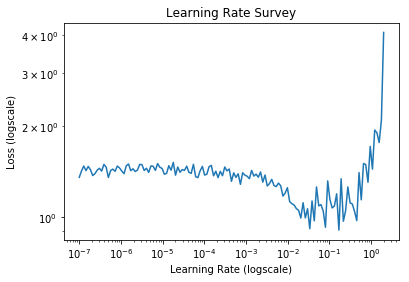

In [6]:
survey_monitor = trainer.survey_learning_rate(
    num_epochs=0.05,
    min_learning_rate=1e-7,
    max_learning_rate=1e1,
    stop_factor=3)
survey_monitor.dataframe_monitor.plot_learning_rate_survey()

In [7]:
trainer.model.set_schedule('learning_rate', 1e-2)
trainer.model.print_schedule_summary()
trainer.train(num_epochs=2)

head.learning_rate: Constant(value=0.01)
6000/6000 [==============================] - 887s 148ms/step - loss: 0.6273 - val_loss: 0.6268


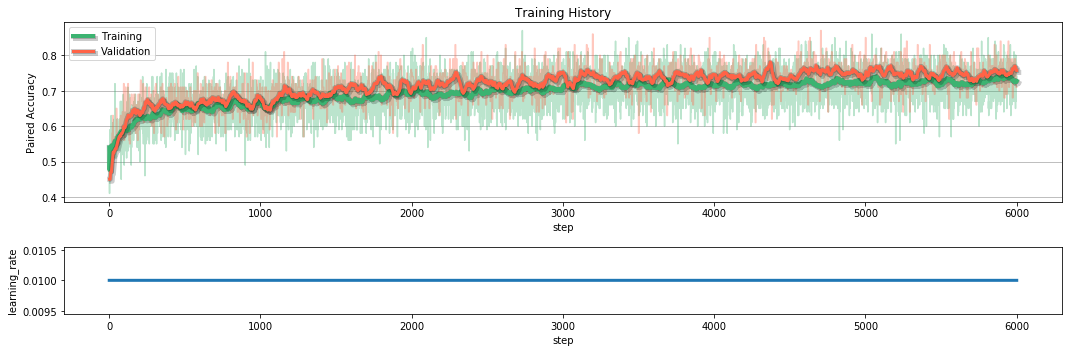

In [8]:
trainer.monitor.dataframe_monitor.plot(skip_first=0, metrics=['paired_accuracy']);

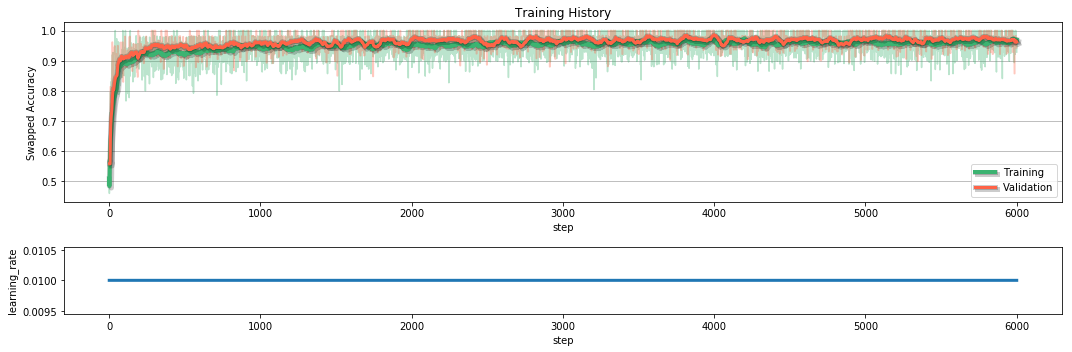

In [9]:
trainer.monitor.dataframe_monitor.plot(skip_first=0, metrics=['swapped_accuracy']);

In [10]:
trainer.model.unfreeze()
model.set_optimizer(optim.SGD, lr=1e-1, momentum=0.9, weight_decay=5e-4)
trainer.model.get_parameter_group('head').set_schedule('learning_rate', 1e-3)
trainer.model.get_parameter_group('base2').set_schedule('learning_rate', 1e-4)
trainer.model.get_parameter_group('base1').set_schedule('learning_rate', 1e-5)
trainer.model.print_schedule_summary()
trainer.train(num_epochs=1)

head.learning_rate: Constant(value=0.001)
base1.learning_rate: Constant(value=1e-05)
base2.learning_rate: Constant(value=0.0001)
3000/3000 [==============================] - 787s 262ms/step - loss: 0.4106 - val_loss: 0.3974


In [11]:
from sconce.schedules import Linear
trainer.model.set_schedule('alpha', Linear(initial_value=0.0, final_value=0.5))
trainer.model.print_schedule_summary()
trainer.train(num_epochs=2)

model.alpha: Linear(initial_value=0.0, final_value=0.5)
head.learning_rate: Constant(value=0.001)
base1.learning_rate: Constant(value=1e-05)
base2.learning_rate: Constant(value=0.0001)
6000/6000 [==============================] - 1579s 263ms/step - loss: 0.2010 - val_loss: 0.2064


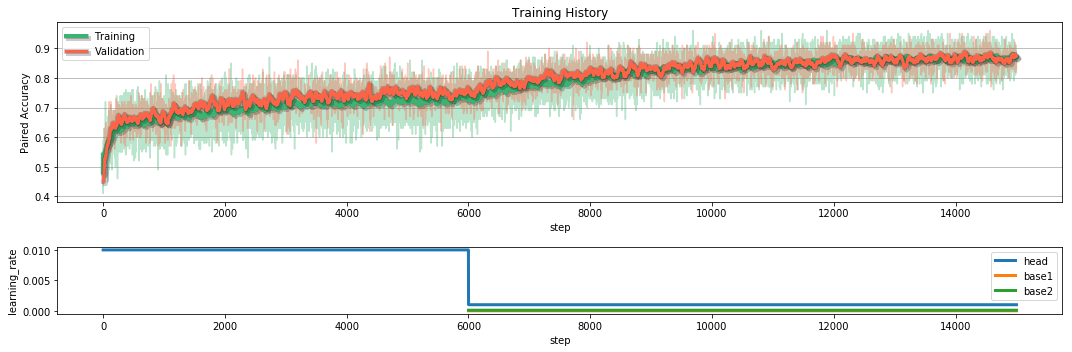

In [12]:
trainer.monitor.dataframe_monitor.plot(skip_first=0, metrics=['paired_accuracy']);

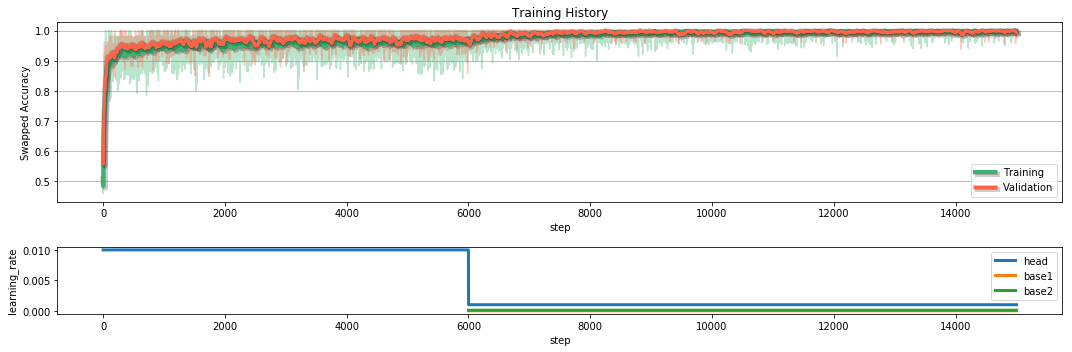

In [13]:
trainer.monitor.dataframe_monitor.plot(skip_first=0, metrics=['swapped_accuracy']);

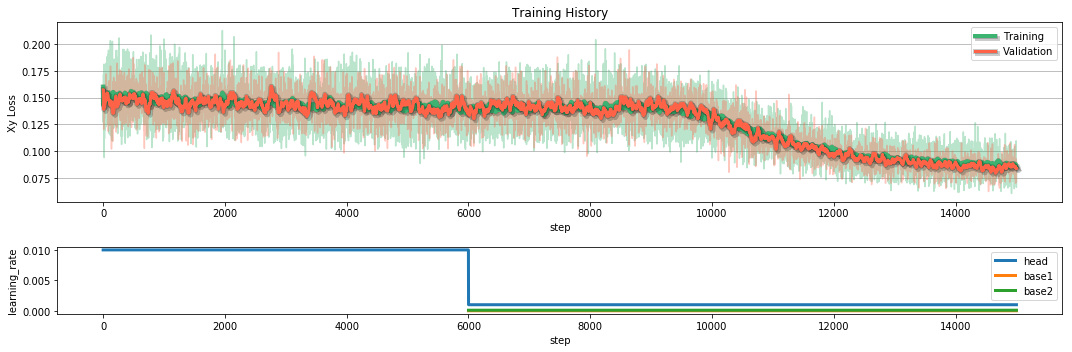

In [14]:
trainer.monitor.dataframe_monitor.plot(skip_first=0, metrics=['xy_loss']);

In [15]:
you_want_to_try_unfreezing_the_resnet_model = False
if you_want_to_try_unfreezing_the_resnet_model:
    for param in model.base_model.parameters():
        param.requires_grad = True
        
    model.build_parameter_groups()
    model.get_num_trainable_parameters()
    model.set_optimizer(optim.SGD, lr=1e-1, momentum=0.9)

    if torch.cuda.is_available():
        model.cuda()

    model.set_schedule('alpha', 0.995)
    model.set_schedule('learning_rate', 5e-2)
    trainer.train(num_epochs=2)

In [16]:
actuals = dict(is_paired=[], is_swapped=[], xy=[])
predictions = dict(is_paired=[], is_swapped=[], xy=[])
validation_feed.reset()
for i in range(len(validation_feed)):
    inputs, targets = validation_feed.next()
    run_dict = trainer._run_model(inputs=inputs, targets=targets, train=False)
                
    is_paired_predictions = run_dict['is_paired'].cpu().data.numpy().argmax(axis=1)
    predictions['is_paired'].append(is_paired_predictions)
    
    is_paired = targets[0].squeeze().cpu().data.numpy()
    actuals['is_paired'].append(is_paired)
    
    is_swapped_predictions = run_dict['is_swapped'].cpu().data.numpy().argmax(axis=1)
    predictions['is_swapped'].append(is_swapped_predictions)
    
    is_swapped = targets[1].squeeze().cpu().data.numpy()
    actuals['is_swapped'].append(is_swapped)
    
    xy_predictions = run_dict['outputs'].cpu().data.numpy()
    predictions['xy'].append(xy_predictions)
    
    xy = targets[2].squeeze().cpu().data.numpy()
    actuals['xy'].append(xy)
    
for key in ('is_paired', 'is_swapped', 'xy'):
    predictions[key] = np.concatenate(predictions[key], axis=0)
    actuals[key] = np.concatenate(actuals[key], axis=0)
    
masks = actuals['is_paired']
paired_accuracy = (predictions['is_paired'] - actuals['is_paired'] == 0).sum() / len(predictions['is_paired'])

swapped_out = predictions['is_swapped']
swapped_in = actuals['is_swapped']
swapped_out_masked = np.where(masks, swapped_out, 2*np.ones(swapped_out.shape))
swapped_correct_masked = (swapped_in - swapped_out_masked == 0)
swapped_accuracy = swapped_correct_masked.sum() / masks.sum()

In [17]:
paired_accuracy, swapped_accuracy

(0.8683866666666666, 0.9967454516352772)

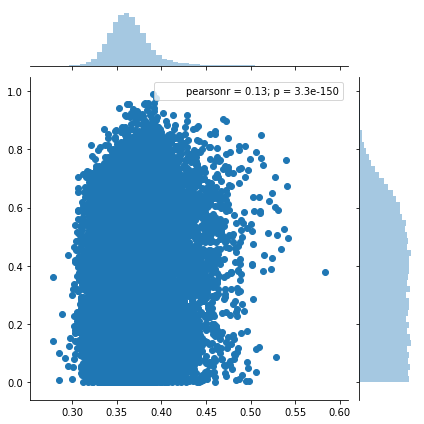

In [18]:
import seaborn as sbn
x_predictions = predictions['xy'].T[0]
x_actuals = actuals['xy'].T[0]

masked_idxs = np.argwhere(masks == 1)

masked_x_predictions = x_predictions[masked_idxs]
masked_x_actuals = x_actuals[masked_idxs]
sbn.jointplot(masked_x_predictions, masked_x_actuals)

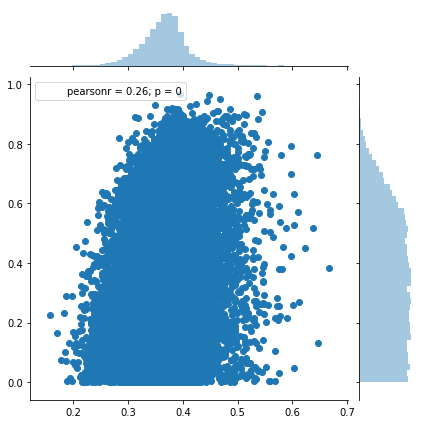

In [19]:
y_predictions = predictions['xy'].T[1]
y_actuals = actuals['xy'].T[1]

masked_idxs = np.argwhere(masks == 1)

masked_y_predictions = y_predictions[masked_idxs]
masked_y_actuals = y_actuals[masked_idxs]
sbn.jointplot(masked_y_predictions, masked_y_actuals)

In [20]:
trainer.save_model_state('saved_weights-resnet.h5')

'saved_weights-resnet.h5'